### Build/train DNN model for PO4.  Use model to predict from validation data (validation905.xlsx) and save output.

month, day, week, ghi, temp, ph, ec, turb, Do, NO3, NH4 to predict PO4

---
---
---

##### Make sure we have these modules

In [1]:
!pip install -q pandas

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!pip install -q sklearn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
!pip install -q openpyxl

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


##### Imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
np.set_printoptions(precision=3, suppress=True)

In [6]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.0


In [7]:
from sklearn.metrics import r2_score

In [8]:
from sklearn.metrics import mean_absolute_error

##### Prep GPU

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---
---
---

#### Some useful functions

##### Build and compile a dense NN with a normalizer

In [10]:
def build_and_compile_model(normalizer):
  model = keras.Sequential([
      normalizer,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [11]:
def plot_loss(history, var_name):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel(f'Error [{var_name}]')
  plt.legend()
  plt.grid(True)

---
---
---

#### Begin PO4

In [12]:
data = pd.read_excel("training905.xlsx",na_values="NaN",  engine='openpyxl')

In [13]:
data.head()

,datetime,Year,Time,Month,Day,Week,GHI,TEMP,PH,EC,TURB,SA DO,SA NO3,SA NH4,SA PO4
0,2016-01-01 00:00:00,2016,00:00:00,1,1,1,2.350,10.000,7.870,1882.000,27.000,8.900,21.300,0.810,0.310
1,2016-01-01 00:00:00,2016,00:00:00,1,1,1,2.350,9.759,7.842,1901.641,26.753,9.174,21.555,0.799,0.289
2,2016-01-01 00:00:00,2016,00:00:00,1,1,1,2.350,9.816,7.858,1923.555,26.720,9.551,21.220,0.595,0.275
3,2016-01-01 00:00:00,2016,00:00:00,1,1,1,2.350,9.806,7.856,1837.397,26.445,8.348,21.830,0.916,0.362
4,2016-01-01 00:15:00,2016,00:15:00,1,1,1,2.337,10.000,7.860,1885.000,27.000,9.000,21.300,0.810,0.310


In [14]:
data.tail()

,datetime,Year,Time,Month,Day,Week,GHI,TEMP,PH,EC,TURB,SA DO,SA NO3,SA NH4,SA PO4
433327,2020-12-31 23:30:00,2020,23:30:00,12,31,5,1.815,7.747,8.394,699.830,NaN,12.233,13.181,-0.072,0.123
433328,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,7.600,8.340,715.000,NaN,12.200,13.400,0.160,0.180
433329,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,7.701,8.338,695.460,NaN,11.723,13.465,0.108,0.205
433330,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,8.070,8.304,681.666,NaN,12.485,12.408,-0.058,0.244
433331,2020-12-31 23:45:00,2020,23:45:00,12,31,5,1.733,7.495,8.356,756.958,NaN,11.342,13.893,0.065,0.165


In [15]:
data.columns

Index(['datetime', 'Year', 'Time', 'Month', 'Day', 'Week', 'GHI', 'TEMP', 'PH',
       'EC', 'TURB', 'SA DO', 'SA NO3', 'SA NH4', 'SA PO4'],
      dtype='object')

In [16]:
data = data.fillna(data.mean())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


Save the clean data as csv.

In [17]:
data.to_csv('training905.csv', index=False)

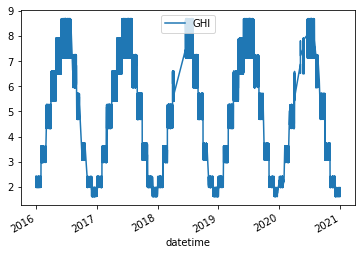

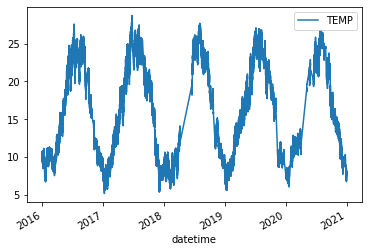

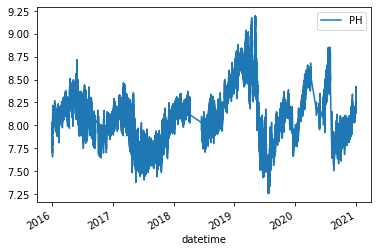

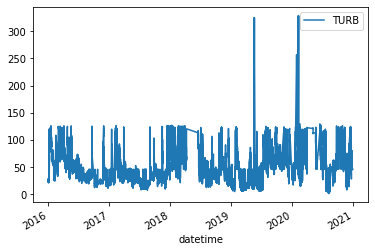

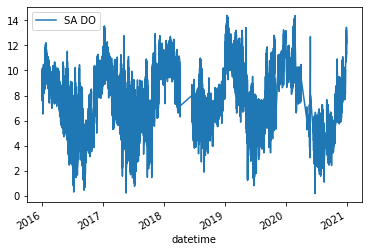

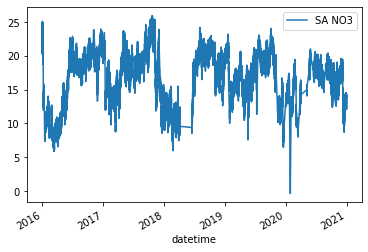

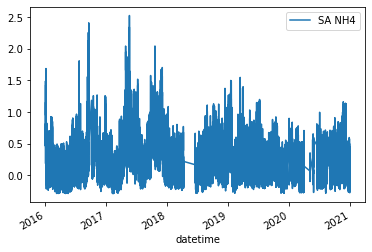

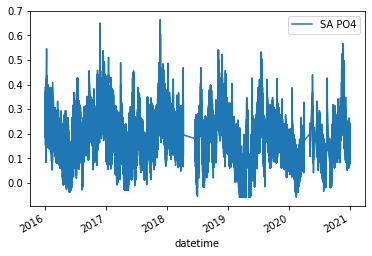

In [18]:
for val in ['GHI', 'TEMP', 'PH',
       'TURB', 'SA DO', 'SA NO3', 'SA NH4', 'SA PO4']:
    data.plot(x='datetime', y=val)

### Split the data into train and test

Now split the dataset into a training set and a test set. Note use of sample. That grabs a random selection of data of the desired size.

We will use the test set for validation in training phase of our models.

In [19]:
train_data = data.sample(frac=0.9, random_state=0)
test_data = data.drop(train_data.index)

In [20]:
len(train_data)

389999

In [21]:
len(test_data)

43333

#### Look at ranges of data...

In [22]:
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,389999.0,2017.800035,1.354273,2016.000,2017.000,2018.000,2019.0000,2020.000
Month,389999.0,6.542648,3.512460,1.000,3.000,7.000,10.0000,12.000
Day,389999.0,15.617479,8.850489,1.000,8.000,16.000,23.0000,31.000
Week,389999.0,2.686563,1.279137,1.000,2.000,3.000,4.0000,5.000
GHI,389999.0,4.797451,2.206960,1.620,2.387,4.872,6.8390,8.690
TEMP,389999.0,16.067202,6.217601,5.132,10.099,15.700,22.2000,28.733
PH,389999.0,8.084271,0.292527,7.255,7.895,8.067,8.2340,9.200
EC,389999.0,1590.915175,580.889936,363.915,1097.687,1688.593,2071.0640,2759.993
TURB,389999.0,45.990564,25.651363,1.306,26.796,40.543,60.9565,328.799
SA DO,389999.0,7.659964,2.404185,0.218,5.837,7.700,9.5460,14.384


### Split features from targets

Separate the target values from the features.  

We're building 4 models:

- month, day, week, ghi, temp, ph, ec, turb, to predict DO

- __month, day, week, ghi, temp, ph, ec, turb, Do to predict NO3__

- month, day, week, ghi, temp, ph, ec, turb, Do, NO3 to predict NH4

- month, day, week, ghi, temp, ph, ec, turb, Do, NO3, NH4 o predict PO4

Columns: 
['datetime', 'Year', 'Time', 'Month', 'Day', 'Week', 'GHI', 'TEMP', 'PH',
       'EC', 'TURB', 'SA DO', 'SA NO3', 'SA NH4', 'SA PO4'

In [23]:
po4_features = [ 'Month', 'Day', 'Week', 'GHI', 'TEMP', 
                'PH', 'EC', 'TURB', 'SA DO', 'SA NO3', 'SA NH4']

In [24]:
po4_target = ['SA PO4']

In [25]:
train_data[po4_features].head()

,Month,Day,Week,GHI,TEMP,PH,EC,TURB,SA DO,SA NO3,SA NH4
121339,4,12,2,5.459,17.320,7.894,1340.190,45.961843,8.607,14.603,0.457
288783,1,15,3,2.237,8.040,8.712,1853.642,21.243000,12.160,19.685,0.830
101841,2,5,1,3.112,9.368,8.154,1060.954,113.972000,9.916,15.635,0.242
285799,1,7,1,2.201,6.825,8.559,1820.651,22.572000,12.320,19.205,0.868
380441,2,13,2,3.629,11.660,8.271,1142.789,36.890000,11.398,13.047,0.290


In [26]:
test_data[po4_features].head()

,Month,Day,Week,GHI,TEMP,PH,EC,TURB,SA DO,SA NO3,SA NH4
21,1,1,1,1.987,9.766,7.848,1907.415,27.995,9.387,20.868,0.663
27,1,1,1,2.099,9.803,7.842,1849.197,26.633,9.675,20.475,0.970
43,1,1,1,2.024,10.438,7.854,1892.609,28.255,8.153,21.352,0.766
46,1,1,1,2.155,9.697,7.864,1851.037,27.491,9.445,21.662,0.743
92,1,1,1,2.275,10.000,7.830,1899.000,27.000,8.800,21.900,1.030


In [27]:
train_data[po4_target].head()

,SA PO4
121339,0.217
288783,0.115
101841,0.269
285799,0.233
380441,0.014


In [28]:
test_data[po4_target].head()

,SA PO4
21,0.274
27,0.212
43,0.216
46,0.330
92,0.260


In [29]:
train_data[po4_features].describe().transpose()[['50%', 'mean', 'std' ]]

,50%,mean,std
Month,7.000,6.542648,3.512460
Day,16.000,15.617479,8.850489
Week,3.000,2.686563,1.279137
GHI,4.872,4.797451,2.206960
TEMP,15.700,16.067202,6.217601
PH,8.067,8.084271,0.292527
EC,1688.593,1590.915175,580.889936
TURB,40.543,45.990564,25.651363
SA DO,7.700,7.659964,2.404185
SA NO3,17.524,16.820512,3.795309


### The Normalization layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [30]:
po4_normalizer = preprocessing.Normalization()

In [31]:
po4_normalizer.adapt(np.array(train_data[po4_features]))

In [32]:
print(po4_normalizer.mean.numpy())

[   6.543   15.617    2.687    4.797   16.067    8.084 1590.915   45.991
    7.66    16.821    0.327]


In [33]:
first = np.array(train_data[po4_features][:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', po4_normalizer(first).numpy())

First example: [[   4.     12.      2.      5.46   17.32    7.89 1340.19   45.96    8.61
    14.6     0.46]]

Normalized: [[-0.72 -0.41 -0.54  0.3   0.2  -0.65 -0.43 -0.    0.39 -0.58  0.46]]


#### Start with linear regression

In [34]:
po4_linear_model = tf.keras.Sequential([
    po4_normalizer,
    layers.Dense(units=1)
])

#### Call the model to build its weight matrices

In [35]:
po4_linear_model.predict(train_data[po4_features][:10])

array([[ 1.003],
       [-1.351],
       [ 0.906],
       [-1.165],
       [-0.712],
       [ 0.509],
       [-0.541],
       [ 0.642],
       [ 0.011],
       [-1.243]], dtype=float32)

#### Compile

In [36]:
po4_linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

#### Train

In [37]:
%%time
history = po4_linear_model.fit(
    train_data[po4_features], train_data[po4_target], 
    epochs=20,
    # don't suppress logging
    verbose=1,
    # Calculate validation results on 10% of the training data
    validation_split = 0.1)

Epoch 1/20
10969/10969 [==============================] - 12s 1ms/step - loss: 0.1057 - val_loss: 0.1069
Epoch 2/20
10969/10969 [==============================] - 10s 895us/step - loss: 0.1001 - val_loss: 0.1014
Epoch 3/20
10969/10969 [==============================] - 11s 973us/step - loss: 0.0995 - val_loss: 0.1093
Epoch 4/20
10969/10969 [==============================] - 9s 847us/step - loss: 0.1002 - val_loss: 0.0967
Epoch 5/20
10969/10969 [==============================] - 10s 897us/step - loss: 0.1000 - val_loss: 0.0916
Epoch 6/20
10969/10969 [==============================] - 10s 900us/step - loss: 0.0994 - val_loss: 0.1338
Epoch 7/20
10969/10969 [==============================] - 8s 690us/step - loss: 0.1001 - val_loss: 0.1569
Epoch 8/20
10969/10969 [==============================] - 13s 1ms/step - loss: 0.0994 - val_loss: 0.0767
Epoch 9/20
10969/10969 [==============================] - 13s 1ms/step - loss: 0.1001 - val_loss: 0.1016
Epoch 10/20
10969/10969 [====================

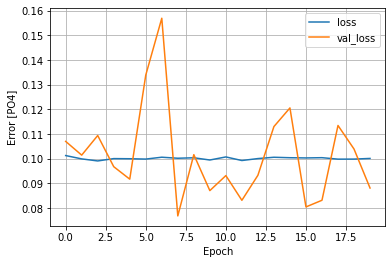

In [38]:
plot_loss(history, 'PO4')

##### Eval this model and store results

In [39]:
test_results = {}

test_results['po4_linear_model'] = po4_linear_model.evaluate(
    test_data[po4_features], test_data[po4_target], verbose=0)

In [40]:
po4_linear_model.metrics_names

['loss']

In [41]:
test_results

{'po4_linear_model': 0.08783530443906784}

In [42]:
po4_lin_model_yhat = po4_linear_model.predict(test_data[po4_features])

##### Adjust limits for PO4

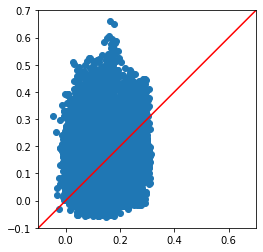

In [43]:
a = plt.axes(aspect='equal')
plt.scatter(po4_lin_model_yhat, test_data[po4_target])
lims = [-0.1,0.7]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, color='red')

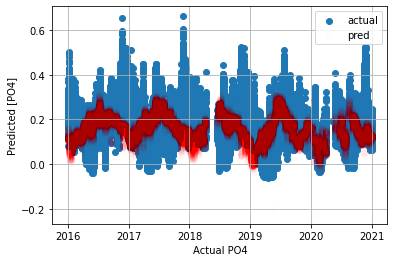

In [44]:
plt.scatter(test_data['datetime'], test_data[po4_target], label='actual')
plt.scatter(test_data['datetime'], po4_lin_model_yhat, color='red', alpha=0.01, label='pred')
plt.xlabel('Actual PO4')
plt.ylabel('Predicted [PO4]')
plt.legend()
plt.grid(True)

In [45]:
r2_score(test_data[po4_target], po4_lin_model_yhat)

-0.5492515327366059

#### Model is not great, but we didn't expect it to be.

### DNN model for nh4

In [46]:
po4_dnn_model = build_and_compile_model(po4_normalizer)

In [47]:
po4_dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 11)                23        
_________________________________________________________________
dense_1 (Dense)              (None, 64)                768       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 5,016
Trainable params: 4,993
Non-trainable params: 23
_________________________________________________________________


In [48]:
%%time
history = po4_dnn_model.fit(
    train_data[po4_features], train_data[po4_target], 
    epochs=20,
    # don't suppress logging
    verbose=1,
    # Calculate validation results on 10% of the training data
    validation_split = 0.1)

Epoch 1/20
10969/10969 [==============================] - 16s 1ms/step - loss: 0.0496 - val_loss: 0.0375
Epoch 2/20
10969/10969 [==============================] - 16s 1ms/step - loss: 0.0365 - val_loss: 0.0358
Epoch 3/20
10969/10969 [==============================] - 18s 2ms/step - loss: 0.0349 - val_loss: 0.0341
Epoch 4/20
10969/10969 [==============================] - 19s 2ms/step - loss: 0.0340 - val_loss: 0.0338
Epoch 5/20
10969/10969 [==============================] - 16s 1ms/step - loss: 0.0335 - val_loss: 0.0333
Epoch 6/20
10969/10969 [==============================] - 17s 2ms/step - loss: 0.0330 - val_loss: 0.0334
Epoch 7/20
10969/10969 [==============================] - 16s 1ms/step - loss: 0.0329 - val_loss: 0.0326
Epoch 8/20
10969/10969 [==============================] - 17s 2ms/step - loss: 0.0325 - val_loss: 0.0326
Epoch 9/20
10969/10969 [==============================] - 16s 1ms/step - loss: 0.0324 - val_loss: 0.0324
Epoch 10/20
10969/10969 [==============================

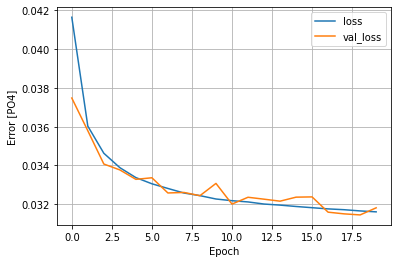

In [49]:
plot_loss(history, 'PO4')

##### Eval this model and store results

In [50]:
test_results['po4_dnn_model'] = po4_dnn_model.evaluate(
    test_data[po4_features], test_data[po4_target], verbose=0)

In [51]:
test_results

{'po4_linear_model': 0.08783530443906784, 'po4_dnn_model': 0.03184109553694725}

In [52]:
po4_dnn_model_yhat = po4_dnn_model.predict(test_data[po4_features])

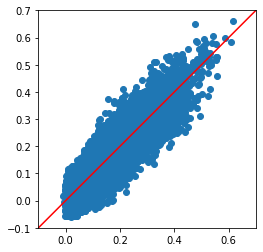

In [53]:
a = plt.axes(aspect='equal')
plt.scatter(po4_dnn_model_yhat, test_data[po4_target])
lims = [-0.1,0.7]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, color='red')

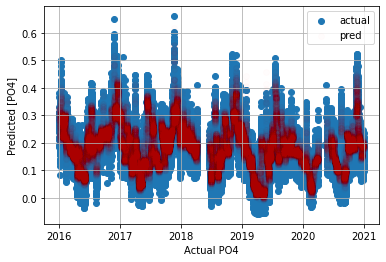

In [54]:
plt.scatter(test_data['datetime'], test_data[po4_target], label='actual')
plt.scatter(test_data['datetime'], po4_dnn_model_yhat, color='red', alpha=0.01, label='pred')
plt.xlabel('Actual PO4')
plt.ylabel('Predicted [PO4]')
plt.legend()
plt.grid(True)

In [55]:
r2_score(test_data[po4_target], po4_dnn_model_yhat)

0.781370192138311

#####  Model captures much more of the variation.

### Save model and predictions

In [56]:
po4_dnn_model.save('po4_dnn_model')

INFO:tensorflow:Assets written to: po4_dnn_model/assets


In [57]:
reload_po4_dnn_model = tf.keras.models.load_model('po4_dnn_model')

check reloaded model

In [58]:
test_results['reloaded'] = reload_po4_dnn_model.evaluate(
    test_data[po4_features], test_data[po4_target], verbose=0)

In [59]:
test_results

{'po4_linear_model': 0.08783530443906784,
 'po4_dnn_model': 0.03184109553694725,
 'reloaded': 0.03184109553694725}

In [60]:
pd.DataFrame(test_results, index=['Mean absolute error [PO4]']).T

,Mean absolute error [PO4]
po4_linear_model,0.087835
po4_dnn_model,0.031841
reloaded,0.031841


##### Get the validation data and examine

In [61]:
val_data = pd.read_excel("validation905.xlsx",na_values="NaN",  engine='openpyxl')

In [62]:
val_data.head()

,datetime,Year,Time,Month,Day,Week,GHI,TEMP,PH,EC,TURB,SA DO,SA NO3,SA NH4,SA PO4
0,2021-01-04 19:00:00,2021,19:00:00,1,4,1,2.386,7.3,8.39,679,51,11.7,12.5,0.13,0.16
1,2021-01-04 19:15:00,2021,19:15:00,1,4,1,2.138,7.3,8.38,680,54,11.7,12.5,0.13,0.16
2,2021-01-04 19:30:00,2021,19:30:00,1,4,1,2.026,7.3,8.38,681,56,11.7,12.5,0.13,0.16
3,2021-01-04 19:45:00,2021,19:45:00,1,4,1,2.149,7.3,8.38,681,58,11.7,12.6,0.13,0.16
4,2021-01-04 20:00:00,2021,20:00:00,1,4,1,2.370,7.3,8.38,680,58,11.7,12.5,0.14,0.16


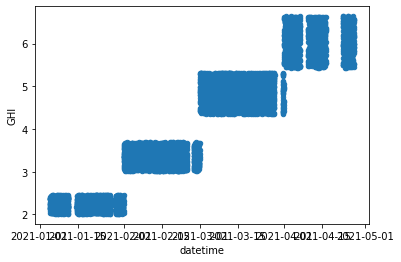

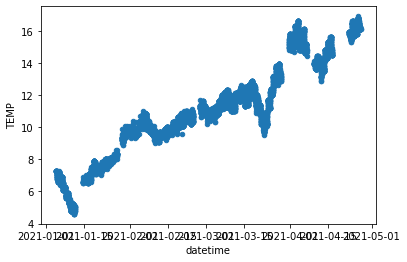

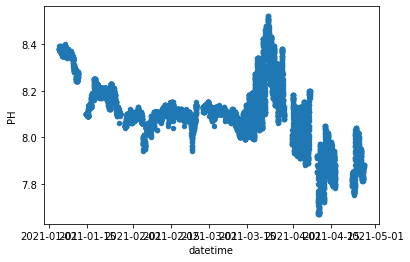

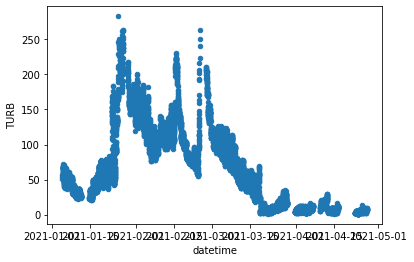

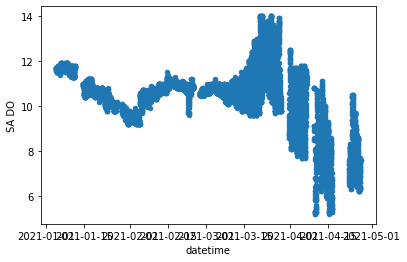

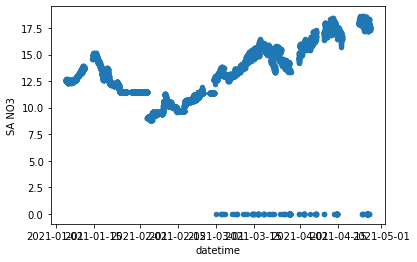

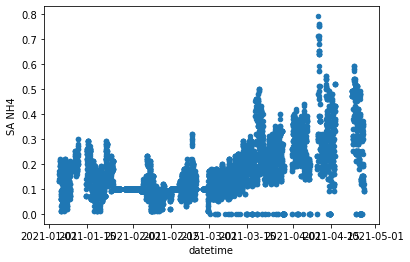

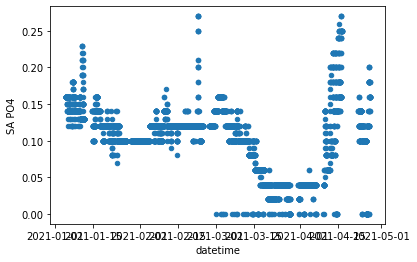

In [63]:
for val in ['GHI', 'TEMP', 'PH',
       'TURB', 'SA DO', 'SA NO3', 'SA NH4', 'SA PO4']:
    val_data.plot(x='datetime', y=val, kind='scatter')

##### Predict NH4

In [64]:
po4_val_yhats = reload_po4_dnn_model.predict(val_data[po4_features])

In [65]:
r2_score(val_data[po4_target], po4_val_yhats)

-5.362994617271958

In [66]:
mean_absolute_error(val_data[po4_target], po4_val_yhats)

0.1000375455225374

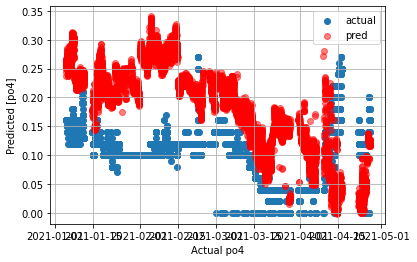

In [67]:
plt.scatter(val_data['datetime'], val_data[po4_target], label='actual')
plt.scatter(val_data['datetime'], po4_val_yhats, color='red', alpha=0.5, label='pred')
plt.xlabel('Actual po4')
plt.ylabel('Predicted [po4]')
plt.legend()
plt.grid(True)

Save the predictions along with time and actual DO.

In [68]:
po4_val_output = pd.DataFrame()

In [69]:
po4_val_output['datetime'] = val_data['datetime']

In [70]:
po4_val_output['predicted po4'] = po4_val_yhats

In [71]:
po4_val_output['actual po4'] = val_data['SA PO4']

In [72]:
po4_val_output.head()

,datetime,predicted po4,actual po4
0,2021-01-04 19:00:00,0.265601,0.16
1,2021-01-04 19:15:00,0.259622,0.16
2,2021-01-04 19:30:00,0.259454,0.16
3,2021-01-04 19:45:00,0.260802,0.16
4,2021-01-04 20:00:00,0.259616,0.16


<AxesSubplot:xlabel='datetime'>

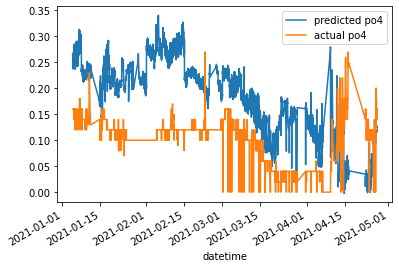

In [73]:
po4_val_output.plot(x='datetime')

In [74]:
po4_val_output.to_csv('dnn_predicted_po4.csv', index=False)

##### check saved output

In [75]:
out = pd.read_csv('dnn_predicted_po4.csv')

In [76]:
out.head()

,datetime,predicted po4,actual po4
0,2021-01-04 19:00:00,0.265601,0.16
1,2021-01-04 19:15:00,0.259622,0.16
2,2021-01-04 19:30:00,0.259454,0.16
3,2021-01-04 19:45:00,0.260802,0.16
4,2021-01-04 20:00:00,0.259616,0.16


<AxesSubplot:xlabel='datetime'>

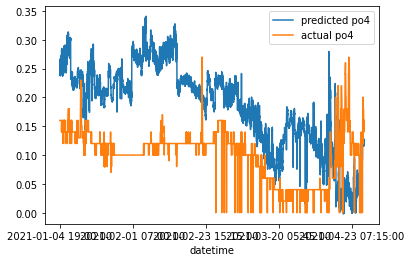

In [77]:
out.plot(x='datetime')